**逻辑回归神经网络实现手写数字识别**

-----------------------

# 1 - 导入模块

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import  Image
from ld_mnist import load_digits

%matplotlib inline

# 2 - 导入数据及数据预处理

In [3]:
mnist = load_digits()

Extracting C:/Users/marsggbo/Documents/Code/ML/TF Tutorial/data/MNIST_data\train-images-idx3-ubyte.gz
Extracting C:/Users/marsggbo/Documents/Code/ML/TF Tutorial/data/MNIST_data\train-labels-idx1-ubyte.gz
Extracting C:/Users/marsggbo/Documents/Code/ML/TF Tutorial/data/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting C:/Users/marsggbo/Documents/Code/ML/TF Tutorial/data/MNIST_data\t10k-labels-idx1-ubyte.gz


In [4]:
print("Train: "+ str(mnist.train.images.shape))
print("Train: "+ str(mnist.train.labels.shape))
print("Test: "+ str(mnist.test.images.shape))
print("Test: "+ str(mnist.test.labels.shape))

Train: (55000, 784)
Train: (55000, 10)
Test: (10000, 784)
Test: (10000, 10)


mnist数据采用的是TensorFlow的一个函数进行读取的，由上面的结果可以知道训练集数据X_train有55000个，每个X的数据长度是784（28*28）。

另外由于数据集的数量较多，所以TensorFlow提供了批量提取数据的方法，从而大大提高了运行速率，方法如下：

```python
x_batch, y_batch = mnist.train.next_batch(100)
print(x_batch.shape)
print(y_batch.shape)

>>>
(100, 784)
(100, 10)
```

In [5]:
x_train, y_train, x_test, y_test = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

因为训练集的数据太大，所以可以再划分成训练集，验证集，测试集，比例为6:2:2

In [6]:
x_train_batch, y_train_batch = mnist.train.next_batch(30000)
x_cv_batch, y_cv_batch = mnist.train.next_batch(15000)
x_test_batch, y_test_batch = mnist.train.next_batch(10000)
print(x_train_batch.shape)
print(y_cv_batch.shape)
print(y_test_batch.shape)

(30000, 784)
(15000, 10)
(10000, 10)


展示手写数字

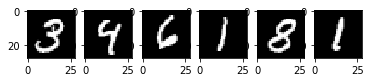

In [7]:
nums = 6
for i in range(1,nums+1):
    plt.subplot(1,nums,i)
    plt.imshow(x_train[i].reshape(28,28), cmap="gray")

# 3 - 算法介绍

## 3.1 算法
对单个样本数据 $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = softmax(z^{(i)})\tag{2}$$ 
损失函数

![cost function](http://www.zhihu.com/equation?tex=L_i%3D-log%28%5Cfrac%7Be%5E%7Bf_%7Byi%7D-max%28f_j%29%7D+%7D%7B%5Csum_j%7Be%5E%7Bf_j-max%28f_j%29%7D%7D%7D+%29)

训练数据集总的损失函数表达式

![J(θ)](http://www.zhihu.com/equation?tex=L+%3D+%5Cfrac%7B1%7D%7BN%7D+%5Csum_i%7BLi%7D%2B%5Clambda+W)


> 需要注意的是公式(1)中的$w^Tx^{(i)}$，这个需要视情况而定,因为需要根据数据维度的不同而进行改变。例如在本次项目中，$x∈R^{55000 × 784}, w∈R^{784 × 10},y∈R^{55000×10}$，所以$z^{(i)} = x^{(i)}w + b$

**关键步骤**
 - 初始化模型参数
 - 使用参数最小化cost function
 - 使用学习得到的参数进行预测
 - 分析结果和总结
 

## 3.2 初始化模型参数

In [8]:
# 初始化模型参数
def init_params(dim1, dim2):
    '''
    dim: 表示权重w的个数，一般来说w维度要与样本x_train.shape[1]和y_train.shape[1]相匹配
    '''
    w = np.zeros((dim1,dim2))
    return w

In [9]:
w  = init_params(2,1)
print(w)

[[ 0.]
 [ 0.]]


## 3.3 定义softmax函数

> 参考[Python - softmax 实现](https://segmentfault.com/a/1190000010039529)

In [10]:
def softmax(x):
    """
    Compute the softmax function for each row of the input x.

    Arguments:
    x -- A N dimensional vector or M x N dimensional numpy matrix.

    Return:
    x -- You are allowed to modify x in-place
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        # Matrix
        exp_minmax = lambda x: np.exp(x - np.max(x))
        denom = lambda x: 1.0 / np.sum(x)
        x = np.apply_along_axis(exp_minmax,1,x)
        denominator = np.apply_along_axis(denom,1,x) 
        
        if len(denominator.shape) == 1:
            denominator = denominator.reshape((denominator.shape[0],1))
        
        x = x * denominator
    else:
        # Vector
        x_max = np.max(x)
        x = x - x_max
        numerator = np.exp(x)
        denominator =  1.0 / np.sum(numerator)
        x = numerator.dot(denominator)
        
    assert x.shape == orig_shape
    return x

In [11]:
a = np.array([[1,2,3,4],[1,2,3,4]])
print(softmax(a))
np.sum(softmax(a))

[[ 0.0320586   0.08714432  0.23688282  0.64391426]
 [ 0.0320586   0.08714432  0.23688282  0.64391426]]


2.0

## 3.4 - 前向&反向传播(Forward and Backward propagation)

参数初始化后，可以开始实现FP和BP算法来让参数自学习了。

Forward Propagation:
- 获取数据X
- 计算 $A = softmax(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- 计算 cost function: 

![](http://ufldl.stanford.edu/wiki/images/math/7/6/3/7634eb3b08dc003aa4591a95824d4fbd.png)


In [12]:
def propagation(w, c, X, Y):
    m = X.shape[0]
    A = softmax(np.dot(X,w))
    J  = -1/m * np.sum(Y*np.log(A)) + 0.5*c*np.sum(w*w)
    dw = -1/m * np.dot(X.T, (Y-A)) + c*w
    
    update = {"dw":dw, "cost": J}
    return update

In [13]:
def optimization(w, c, X, Y, learning_rate=0.1, iterations=1000, print_info=False):
    
    costs = []
    
    for i in range(iterations):
        update = propagation(w, c, X, Y)
        w -= learning_rate * update['dw']
        
        if i %100==0:
            costs.append(update['cost'])
            
        if i%100==0 and print_info==True:
            print("Iteration " + str(i+1) + " Cost = " + str(update['cost']))

    
    results = {'w':w, 'costs': costs}
    return results

In [14]:
def predict(w, X):
    return softmax(np.dot(X, w))

In [40]:
def accuracy(y_hat, Y):
    
    # 统计准确率
    max_index = np.argmax(y_hat, axis=1)
    y_hat[np.arange(y_hat.shape[0]), max_index] = 1
    accuracy = np.sum(np.argmax(y_hat, axis=1)==np.argmax(Y, axis=1))   
    accuracy = accuracy *1.0/Y.shape[0]
    return accuracy

In [41]:
def model(w, c, X, Y, learning_rate=0.1, iterations=1000, print_info=False):
    results = optimization(w, c, X, Y, learning_rate, iterations, print_info)
    
    w = results['w']
    costs = results['costs']
    y_hat = predict(w, X)
    
    accuracy = accuracy(y_hat, Y)
    print("After %d iterations,the total accuracy is %f"%(iterations, accuracy))
    results = {
        'w':w,
        'costs':costs,
        'accuracy':accuracy,
        'iterations':iterations,
        'learning_rate':learning_rate,
        'y_hat':y_hat,
        'c':c
    }
    return results

# 4 - 验证模型

In [16]:
w = init_params(x_train_batch.shape[1], y_train_batch.shape[1])
c = 0
results_train = model(w, c, x_train_batch, y_train_batch, learning_rate=0.3, iterations=1000, print_info=True)
print(results_train)

Iteration 1 Cost = 2.30258509299
Iteration 101 Cost = 0.444039646187
Iteration 201 Cost = 0.383446527394
Iteration 301 Cost = 0.357022940232
Iteration 401 Cost = 0.341184601147
Iteration 501 Cost = 0.330260258921
Iteration 601 Cost = 0.322097106964
Iteration 701 Cost = 0.315671301537
Iteration 801 Cost = 0.310423971361
Iteration 901 Cost = 0.306020145234
After 1000 iterations,the total accuracy is 0.915800
{'w': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), 'costs': [2.302585092994045, 0.44403964618714781, 0.38344652739376933, 0.35702294023246306, 0.34118460114650634, 0.33026025892089478, 0.32209710696427363, 0.31567130153696982, 0.31042397136133199, 0.30602014523405535], 'accuracy': 0.91579999999999995, 'iterations': 1000, 'learning_rate': 0.3, 'y_hat': ar

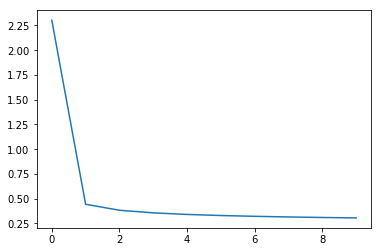

In [19]:
plt.plot(results_train['costs'])

In [21]:
params = [[0, 0.3],[0,0.5],[5,0.3],[5,0.5]]
results_cv = {}
for i in range(len(params)):
    result = model(results_train['w'],0, x_cv_batch, y_cv_batch, learning_rate=0.5, iterations=1000, print_info=False)
    print("{0} iteration done!".format(i))
    results_cv[i] = result

After 1000 iterations,the total accuracy is 0.931333
0 iteration done!
After 1000 iterations,the total accuracy is 0.936867
1 iteration done!
After 1000 iterations,the total accuracy is 0.940200
2 iteration done!
After 1000 iterations,the total accuracy is 0.942200
3 iteration done!


1 iteration accuracy: 0.9313333333333333 
2 iteration accuracy: 0.9368666666666666 
3 iteration accuracy: 0.9402 
4 iteration accuracy: 0.9422 


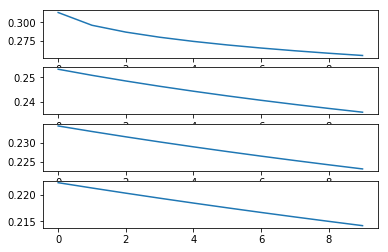

In [31]:
for i in range(len(params)):
    print("{0} iteration accuracy: {1} ".format(i+1, results_cv[i]['accuracy']))
for i in range(len(params)):
    plt.subplot(len(params), 1,i+1)
    plt.plot(results_cv[i]['costs'])

**验证测试集准确率**

In [92]:
y_hat_test = predict(w, x_test_batch)
accu = accuracy(y_hat_test, y_test_batch)
print(accu)

0.9111


# 5 - 测试真实手写数字

读取之前保存的权重数据

In [88]:
# w = results_cv[3]['w']
# np.save('weights.npy',w)

In [89]:
w = np.load('weights.npy')
w.shape

(784, 10)

In [90]:
# 已经将图片转化成txt格式
files = ['3.txt','31.txt','5.txt','8.txt','9.txt','6.txt','91.txt']

# 将txt数据转化成np.array
def pic2np(file):
    with open(file, 'r') as f:
        x = f.readlines()
        data = []

        for i in range(len(x)):
            x[i] = x[i].split('\n')[0]
            for j in range(len(x[0])):
                data.append(int(x[i][j]))
        data = np.array(data)
        return data.reshape(-1,784)

实际值3-预测值6
实际值3-预测值3
实际值5-预测值3
实际值8-预测值3
实际值9-预测值3
实际值6-预测值6
实际值9-预测值7
准确率为0.2857142857142857


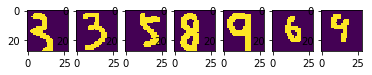

In [91]:
# 验证准确性
i = 1
count = 0
for file in files:
    x = pic2np(file)
    y = np.argmax(predict(w, x))
    
    print("实际值{0}-预测值{1}".format( int(file.split('.')[0][0]) , y) )
    if y == int(file.split('.')[0][0]):
        count += 1
    plt.subplot(2, len(files), i)
    plt.imshow(x.reshape(28,28))
    i += 1
print("准确率为{0}".format(count/len(files)))

由上面的结果可见我自己写的数字还是蛮有个性的。。。。居然7个只认对了2个。看来算法还是需要提高的

# 6 - Softmax 梯度下降算法推导

![Softmax求导过程](http://upload-images.jianshu.io/upload_images/2301760-1c7b8c12bbe6a1bc.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)